In [7]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [8]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import  random_search_forecaster
from skforecast.model_selection import  bayesian_search_forecaster
from sklearn.metrics import mean_squared_error

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


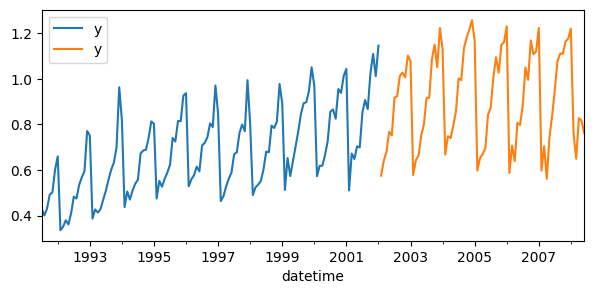

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [9]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

In [10]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15 
             )

metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['y'],
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        steps              = 10,
                        metric             = 'mean_squared_error',
                        refit              = True,
                        verbose            = True,
                        show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00  (n=137)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00  (n=147)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00  (n=157)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2005-05-01 00:00:0

  0%|          | 0/8 [00:00<?, ?it/s]

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


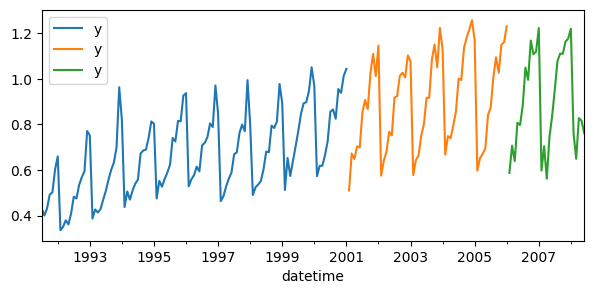

In [11]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [12]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 18.


loop lags_grid:   0%|                                               | 0/3 [00:00<?, ?it/s]

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.03344857370906804

